In [97]:
import numpy as np
import scipy.signal 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from acoustics.cepstrum import complex_cepstrum
from acoustics.cepstrum import real_cepstrum
from acoustics.cepstrum import inverse_complex_cepstrum
from acoustics.cepstrum import minimum_phase

# 1. Waveform

In [98]:
#for rainbow.wav
fs, signal = scipy.io.wavfile.read('audio_files/data_input_rainbow.wav')

Text(0.5, 1.0, 'Waveform')

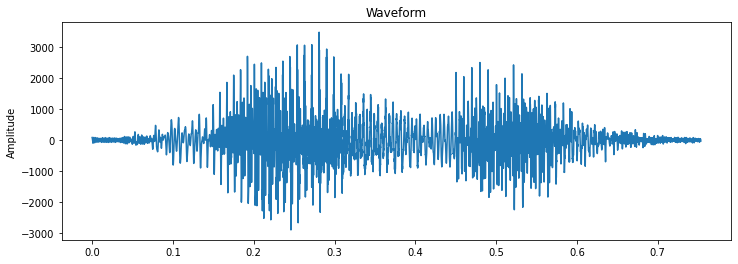

In [99]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
audio_length = len(signal)/fs 
timeaxis = np.linspace(0,audio_length,len(signal))

ax.plot(timeaxis, signal)
ax.set_ylabel('Amplitude')
ax.set_title('Waveform')

# 2. Cepstrum Plots

## 2.1 complex_cepstrum

- Complex cepstrum is calculated by taking the inverse fourier transform of the log of the spectrum
- It contains information about the phase (imaginary part of the complex logarithm)

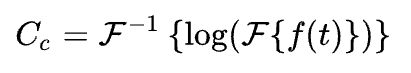

<ipython-input-100-7dfaaac1b625>:15: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(quefrency_vector, 20*np.log10(ceps))


Text(0.5, 1.0, 'Complex_cepstrum in dB')

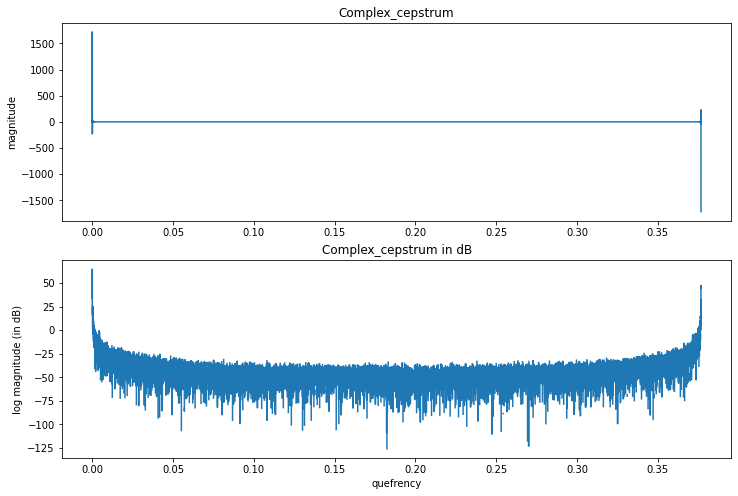

In [100]:
# complex_cepstrum
ceps, _ = complex_cepstrum(signal)

# quefrency
dt = 1/fs
freq_vector = np.fft.rfftfreq(len(signal), d=dt)
df = freq_vector[1] - freq_vector[0]
quefrency_vector = np.fft.rfftfreq(2*ceps.size-2, df)

# plot
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(quefrency_vector, ceps)
ax[0].set_ylabel('magnitude')
ax[0].set_title('Complex_cepstrum')
ax[1].plot(quefrency_vector, 20*np.log10(ceps))
ax[1].set_xlabel('quefrency')
ax[1].set_ylabel('log magnitude (in dB)')
ax[1].set_title('Complex_cepstrum in dB')

## 2.2 real_cepstrum

- Real cepstrum is calculated by taking the inverse fourier transform of the log of the <B> mod of the spectrum </B>
- It contains <B>no information about the phase </B>

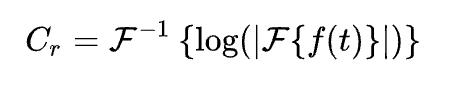

<ipython-input-101-0fbc39e34520>:15: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(quefrency_vector, 20*np.log10(ceps))


Text(0.5, 1.0, 'Real_cepstrum in dB')

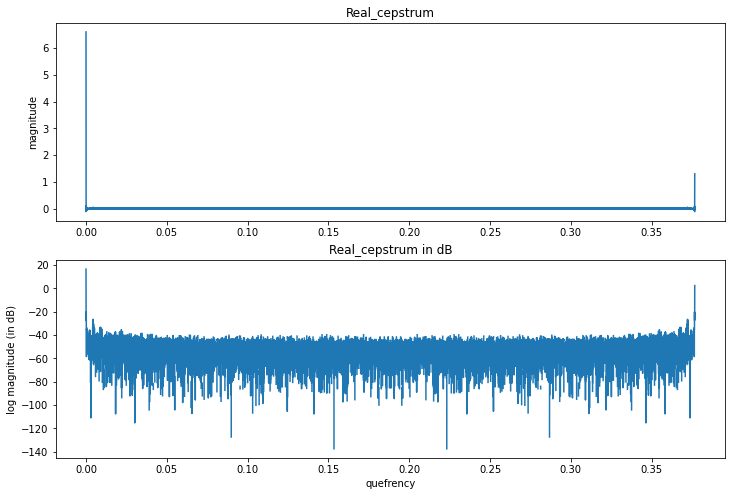

In [101]:
# real_cepstrum
ceps = real_cepstrum(signal)

# quefrency
dt = 1/fs
freq_vector = np.fft.rfftfreq(len(signal), d=dt)
df = freq_vector[1] - freq_vector[0]
quefrency_vector = np.fft.rfftfreq(2*ceps.size-2, df)

# plot
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(quefrency_vector, ceps)
ax[0].set_ylabel('magnitude')
ax[0].set_title('Real_cepstrum')
ax[1].plot(quefrency_vector, 20*np.log10(ceps))
ax[1].set_xlabel('quefrency')
ax[1].set_ylabel('log magnitude (in dB)')
ax[1].set_title('Real_cepstrum in dB')


## 2.3 vfp cepstrum

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'vfp cepstrum in dB')

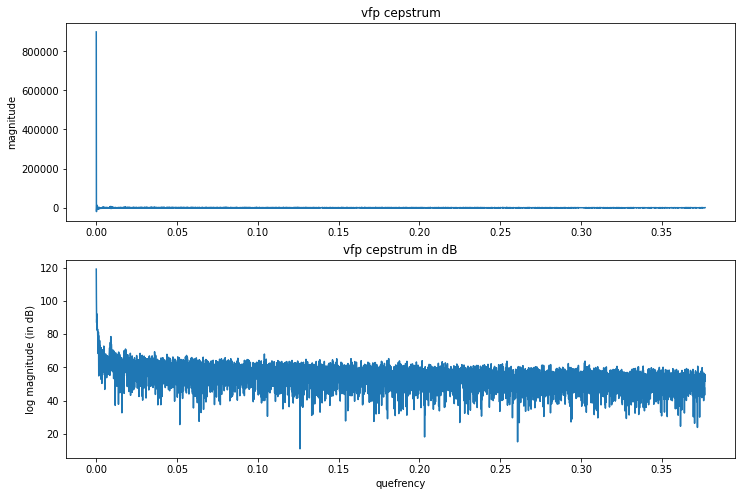

In [102]:
x = signal

x = np.hamming(len(x))*x
spectrum = np.fft.rfft(x)
spectrum = 20*np.log10(np.abs(spectrum))
ceps = np.fft.rfft(spectrum)

dt = 1/fs
freq_vector = np.fft.rfftfreq(len(signal), d=dt)
df = freq_vector[1] - freq_vector[0]
quefrency_vector = np.fft.rfftfreq(2*ceps.size-2, df)

fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(quefrency_vector, ceps)
ax[0].set_ylabel('magnitude')
ax[0].set_title('vfp cepstrum')
ax[1].plot(quefrency_vector, 20*np.log10(ceps))
ax[1].set_xlabel('quefrency')
ax[1].set_ylabel('log magnitude (in dB)')
ax[1].set_title('vfp cepstrum in dB')


# 3. Plotting CPP 

In [103]:
# function for plotting cepstral peak prominence

def cpp_plot(x, fs, pitch_range, trendline_quefrency_range, cepstrum):
    
    # Cepstrum
    if cepstrum == 'complex_cepstrum':
        ceps, _ = complex_cepstrum(x)
    elif cepstrum == 'real_cepstrum':
        ceps = real_cepstrum(x)
    elif cepstrum == 'vfp':
        x = np.hamming(len(x))*x
        spectrum = np.fft.rfft(x)
        spectrum = 20*np.log10(np.abs(spectrum))
        ceps = np.fft.rfft(spectrum) 
    ceps = 20*np.log10(np.abs(ceps))

    # Quefrency
    dt = 1/fs
    freq_vector = np.fft.rfftfreq(len(x), d=dt)
    df = freq_vector[1] - freq_vector[0]
    quefrency_vector = np.fft.rfftfreq(2*ceps.size-2, df)
    
    # Selecting part of cepstrum
    quefrency_range = [1/pitch_range[1], 1/pitch_range[0]]
    index_range = np.where((quefrency_vector >= quefrency_range[0]) & (quefrency_vector <=quefrency_range[1]))

    # For trend line
    index_range_tl = np.where((quefrency_vector >= trendline_quefrency_range[0]) & (quefrency_vector <=trendline_quefrency_range[1]))
    plot_range = np.where((quefrency_vector >= 0) & (quefrency_vector <= 0.0512))
    
    # Linear regression
    linear_regressor = LinearRegression()  
    linear_regressor.fit(quefrency_vector[index_range_tl].reshape(-1, 1), ceps[index_range_tl].reshape(-1, 1))  
    Y_pred = linear_regressor.predict(quefrency_vector.reshape(-1, 1))  
    
    peak_value = np.max(ceps[index_range])
    peak_index = np.argmax(ceps[index_range])

    fig, ax = plt.subplots(1,1, figsize=(12,8))
    ax.plot(quefrency_vector[plot_range], ceps[plot_range])
    ax.plot(quefrency_vector[plot_range], Y_pred[plot_range])
    
    ax.plot(quefrency_vector[index_range][peak_index], peak_value, marker="o",markeredgecolor="red", markerfacecolor="red")
    ax.plot(quefrency_vector[index_range][peak_index], Y_pred[index_range][peak_index], marker="o", markeredgecolor="red", markerfacecolor="red")
    ax.set_xlabel('quefrency[s]')
    ax.set_ylabel('log magnitude(dB)')
    ax.set_title('Cepstrum')
    
    print('The peak is found at quefrency {}s and its value is {}'.format(np.round(quefrency_vector[index_range][peak_index], 5), np.round(peak_value, 5)))
    print('The trendline value at this quefrency is {}'.format(np.round(Y_pred[index_range][peak_index][0], 5)))
    print('The CPP is {} dB'.format(np.round(peak_value - Y_pred[index_range][peak_index][0], 5)))
    


## 3.1 Rainbow.wav

### a) Complex cepstrum

The peak is found at quefrency 0.00431s and its value is -0.55603
The trendline value at this quefrency is -24.06195
The CPP is 23.50592 dB


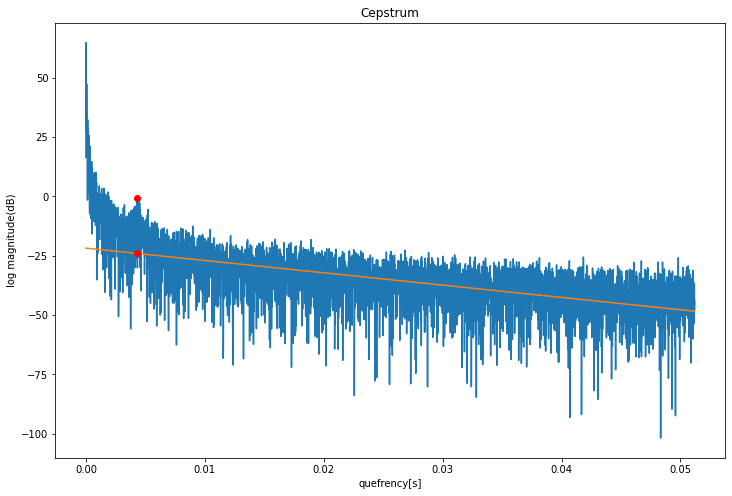

In [104]:
fs, signal = scipy.io.wavfile.read('audio_files/data_input_rainbow.wav')
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'complex_cepstrum')



### b) Real cepstrum

The peak is found at quefrency 0.00448s and its value is -26.59328
The trendline value at this quefrency is -48.44873
The CPP is 21.85545 dB


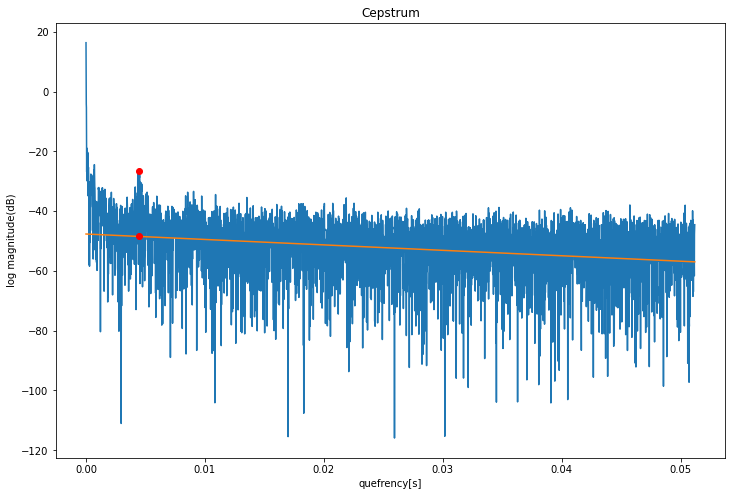

In [105]:
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'real_cepstrum')


### c) VFP cepstrum

The peak is found at quefrency 0.00907s and its value is 78.54759
The trendline value at this quefrency is 63.05206
The CPP is 15.49553 dB


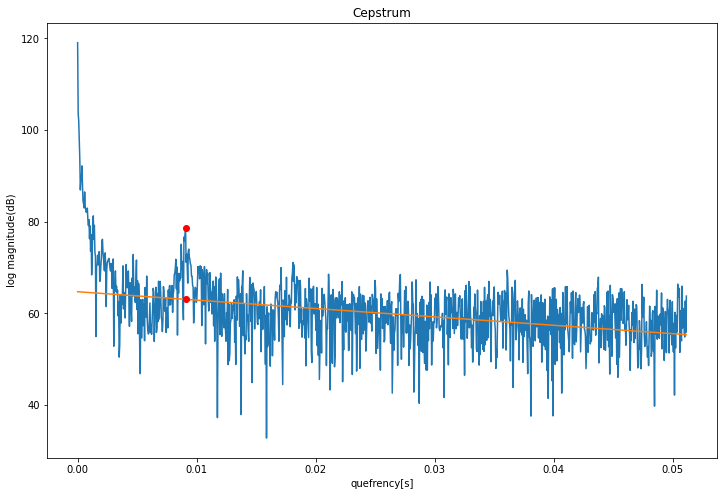

In [106]:
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'vfp')


## 3.2 CantinaBand3.wav

The peak is found at quefrency 0.00308s and its value is 6.2646
The trendline value at this quefrency is -14.10095
The CPP is 20.36555 dB

The peak is found at quefrency 0.00413s and its value is -27.57796
The trendline value at this quefrency is -44.5782
The CPP is 17.00024 dB

The peak is found at quefrency 0.00345s and its value is 87.09498
The trendline value at this quefrency is 74.90381
The CPP is 12.19117 dB


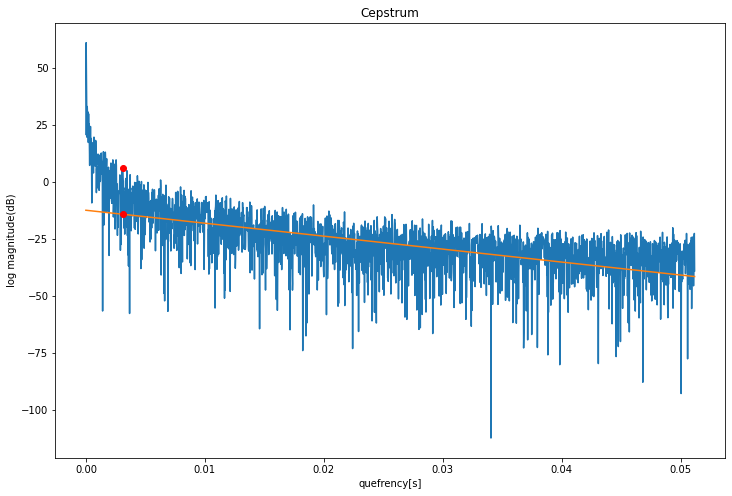

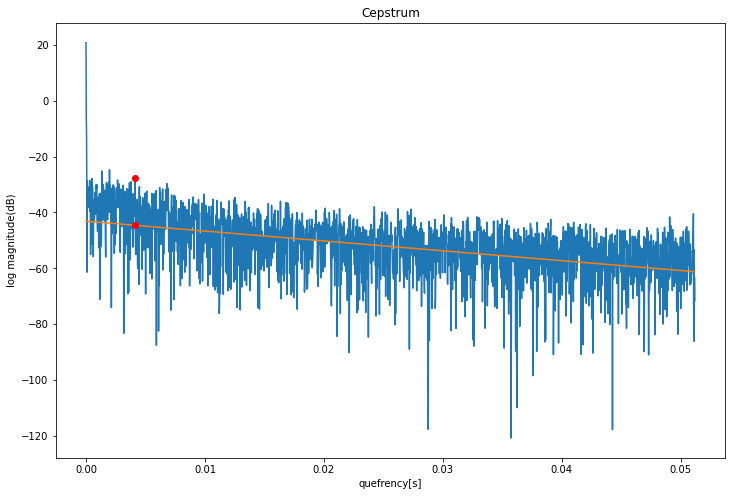

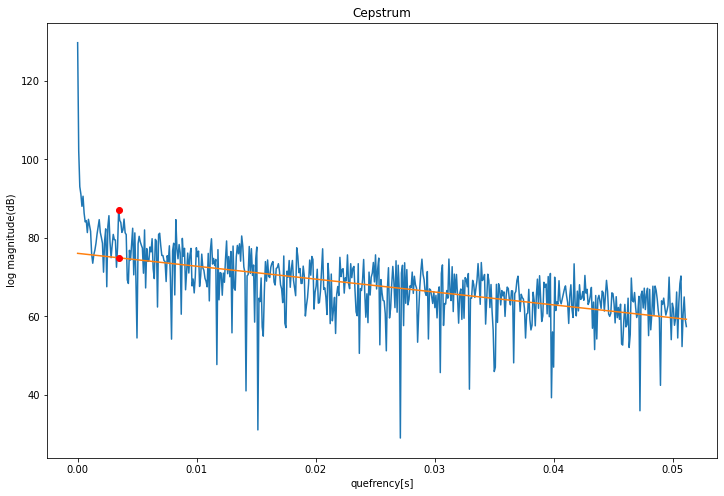

In [107]:
fs, signal = scipy.io.wavfile.read('audio_files/CantinaBand3.wav')
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'complex_cepstrum')
print()
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'real_cepstrum')
print()
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'vfp')

## 3.3 StarWars3.wav

The peak is found at quefrency 0.00311s and its value is 5.63925
The trendline value at this quefrency is -14.59374
The CPP is 20.233 dB

The peak is found at quefrency 0.00429s and its value is -24.71472
The trendline value at this quefrency is -46.44199
The CPP is 21.72726 dB

The peak is found at quefrency 0.00426s and its value is 89.43276
The trendline value at this quefrency is 71.88985
The CPP is 17.54291 dB


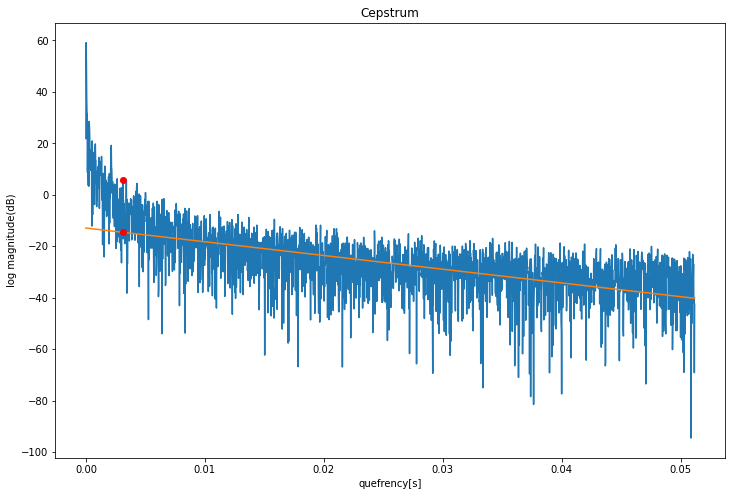

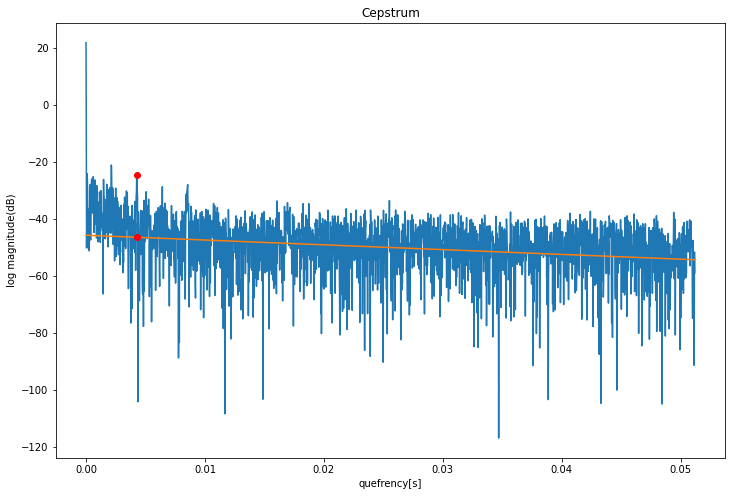

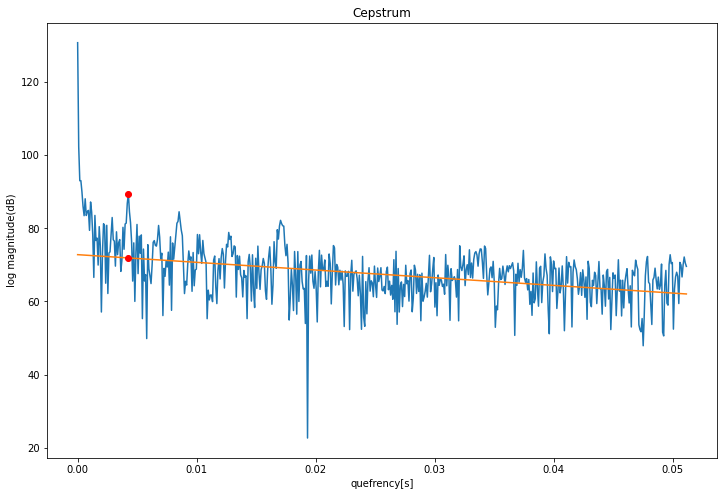

In [108]:
fs, signal = scipy.io.wavfile.read('audio_files/StarWars3.wav')
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'complex_cepstrum')
print()
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'real_cepstrum')
print()
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05], cepstrum = 'vfp')

# 4. Some Observations:

- The vfp CPP is lower than the other two (complex cepstrum CPP and real cepstrum CPP)
- The complex cepstrum and real cepstrum are noisier
- The complex cepstrum and real cepstrum (in dB) are always negative except for the peaks at the ends. The vfp cpp is generally positive
- The complex cepstrum (in dB) is generally lesser than the real cepstrum
